# Import libraries

In [2]:
import datetime as datetime
from feature_extraction.indicator_features import *
from feature_extraction.price_features import *
from feature_extraction.trader_features import *
import matplotlib.pyplot as plt
from models.model import *
# import mplfinance as mpf
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
import pytse_client as tse
from pytse_client.download import download_financial_indexes
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from labeling.zigzag import peak_valley_pivots

# Import data

In [3]:
tse.download(
    symbols = ['فولاد'],
    adjust = True, 
    write_to_csv = True, 
    include_jdate = True
)
ticker = tse.Ticker(
    symbol = 'فولاد',  
    adjust = True
)
ticker_history = ticker.history

ticker_history = ticker_history[ticker_history.columns[:-1].insert(0, ticker_history.columns[-1]).to_list()] # change location of jdate

print(f'Shape of Folad price history: {ticker_history.shape}')
print(50 * '-')
print(f'{ticker_history.info()}')
print(50 * '-')
ticker_history.head()

Shape of Folad price history: (3516, 11)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3516 entries, 0 to 3515
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   jdate      3516 non-null   object        
 1   date       3516 non-null   datetime64[ns]
 2   open       3516 non-null   float64       
 3   high       3516 non-null   float64       
 4   low        3516 non-null   float64       
 5   adjClose   3516 non-null   float64       
 6   value      3516 non-null   int64         
 7   volume     3516 non-null   int64         
 8   count      3516 non-null   int64         
 9   yesterday  3516 non-null   float64       
 10  close      3516 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 302.3+ KB
None
--------------------------------------------------


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0
4,1385-12-26,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0


In [4]:
ticker_traders_types = ticker.client_types
ticker_traders_types = ticker_traders_types.iloc[::-1]
ticker_traders_types.reset_index(
    drop = True,
    inplace = True
)
ticker_traders_types['date'] = ticker_traders_types['date'].apply(
    lambda x: datetime.datetime.strptime(x, '%Y%m%d')
)
ticker_traders_types.iloc[:, 1:] = ticker_traders_types.iloc[:, 1:].astype('float')

print(f"Shape of Folad's client history: {ticker_traders_types.shape}")
print(50 * '-')
print(f'{ticker_traders_types.info()}')
print(50 * '-')
ticker_traders_types.head()

Shape of Folad's client history: (3131, 18)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3131 entries, 0 to 3130
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         3131 non-null   datetime64[ns]
 1   individual_buy_count         3131 non-null   float64       
 2   corporate_buy_count          3131 non-null   float64       
 3   individual_sell_count        3131 non-null   float64       
 4   corporate_sell_count         3131 non-null   float64       
 5   individual_buy_vol           3131 non-null   float64       
 6   corporate_buy_vol            3131 non-null   float64       
 7   individual_sell_vol          3131 non-null   float64       
 8   corporate_sell_vol           3131 non-null   float64       
 9   individual_buy_value         3131 non-null   float64       
 10  corporate_buy

,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change
0,2008-11-26,14.0,2.0,4.0,1.0,106338.0,20010.0,126338.0,10.0,2.489373e+08,4.684412e+07,295757258.0,2.412000e+04,2341.000000,2341.0,2341.035482,2412.000000,-20000.0
1,2008-11-29,116.0,175.0,3.0,2.0,4718258.0,33691903.0,121402.0,38288759.0,1.498023e+10,1.077130e+11,284080680.0,1.224092e+11,3174.949168,2340.0,3196.999767,3196.999795,4596856.0
2,2008-11-30,10.0,2.0,1.0,1.0,87219.0,12791.0,100000.0,10.0,2.040052e+08,2.991886e+07,233900000.0,2.410000e+04,2339.000000,2339.0,2339.055508,2410.000000,-12781.0
3,2008-12-01,8.0,1.0,5.0,1.0,128666.0,10.0,128666.0,10.0,3.008211e+08,2.409000e+04,300821108.0,2.409000e+04,2338.000000,2338.0,2409.000000,2409.000000,0.0
4,2008-12-02,7.0,1.0,1.0,0.0,18553.0,10000.0,28553.0,0.0,4.335836e+07,2.337000e+07,66728361.0,0.000000e+00,2337.000000,2337.0,2337.000000,NaN,-10000.0


In [5]:
market_index = download_financial_indexes(
    symbols = 'شاخص كل', 
    write_to_csv = True
)
market_index = market_index['شاخص كل']
market_index.rename(
    columns = {'value': 'TEDPIX'}, 
    inplace = True
)

print(f'Shape of TEDPIX: {market_index.shape}')
market_index.head()

Shape of TEDPIX: (3430, 2)


,TEDPIX,date
0,9248.9,2008-12-04
1,9248.9,2008-12-05
2,9178.3,2008-12-06
3,9130.5,2008-12-07
4,9089.2,2008-12-08


In [6]:
ticker_history = ticker_history.merge(
    market_index, 
    how = 'left', 
    on = 'date'
)
ticker_history.head()

,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,NaN
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,NaN
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,NaN
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,NaN
4,1385-12-26,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0,NaN


In [7]:
# # plt.figure(figsize = (10, 50))
# # plt.tight_layout()
# dff = ticker_history[['date', 'open', 'high', 'low', 'close','volume']].set_index('date')

# fig, ax = mpf.plot(
#     dff,
#     title = 'Mobarakeh Steel  Stock Price',
#     volume = True,
#     type = 'candle',
#     # style = 'yahoo',
#     figratio = (18,10),
#     figscale = 1.5,
#     datetime_format = '%Y-%m-%d',
#     # marketcolor_overrides = ,
#     tight_layout = True,
#     returnfig=True
#     # tight_layout = True
# )
# ax = ax[0]
# ax.set_yscale('log')

In [8]:
# def plot_chart(data, n, ticker):
    
#     # Filter number of observations to plot
#     data = data.iloc[-n:]
    
#     # Create figure and set axes for subplots
#     fig = plt.figure()
#     fig.set_size_inches((20, 16))
#     ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
#     ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
#     ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
#     ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
#     # Format x-axis ticks as dates
#     ax_candle.xaxis_date()
    
#     # Get nested list of date, open, high, low and close prices
#     ohlc = []
#     for date, row in data.iterrows():
#         openp, highp, lowp, closep = row[:4]
#         ohlc.append([date2num(date), openp, highp, lowp, closep])
 
#     # Plot candlestick chart
#     ax_candle.plot(data.index, data["ma10"], label="MA10")
#     ax_candle.plot(data.index, data["ma30"], label="MA30")
#     candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
#     ax_candle.legend()
    
#     # Plot MACD
#     ax_macd.plot(data.index, data["macd"], label="macd")
#     ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
#     ax_macd.plot(data.index, data["macd_signal"], label="signal")
#     ax_macd.legend()
    
#     # Plot RSI
#     # Above 70% = overbought, below 30% = oversold
#     ax_rsi.set_ylabel("(%)")
#     ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
#     ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
#     ax_rsi.plot(data.index, data["rsi"], label="rsi")
#     ax_rsi.legend()
    
#     # Show volume in millions
#     ax_vol.bar(data.index, data["Volume"] / 1000000)
#     ax_vol.set_ylabel("(Million)")
   
#     # Save the chart as PNG
#     fig.savefig("charts/" + ticker + ".png", bbox_inches="tight")
    
#     plt.show()

# Features

In [9]:
calenderFeatures = calender_features(ticker_history)
candelFeatures = candlestick_feature(ticker_history)
prpFeatures = prp_based(ticker_history)
retFeatures = ret_based(ticker_history)
shiftFeatures = shift_data(ticker_history)
wghtFeatures = weight_feature(ticker_history)

priceFeatures = pd.concat(
    [
        ticker_history,
        calenderFeatures,
        candelFeatures,
        prpFeatures,
        retFeatures,
        shiftFeatures,
        wghtFeatures
    ], axis = 1
)

print(f'Shape of price features: {priceFeatures.shape}')
priceFeatures.head()

Shape of price features: (3516, 132)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,quarter,month,day,weekday,shadow_up_1w,shadow_low_1w,body_1w,mean_to_shadow_up_1w,mean_to_shadow_low_1w,shadow_up_2w,shadow_low_2w,body_2w,mean_to_shadow_up_2w,mean_to_shadow_low_2w,shadow_up_3w,shadow_low_3w,body_3w,mean_to_shadow_up_3w,mean_to_shadow_low_3w,shadow_up_1m,shadow_low_1m,body_1m,mean_to_shadow_up_1m,mean_to_shadow_low_1m,shadow_up_3m,shadow_low_3m,body_3m,mean_to_shadow_up_3m,mean_to_shadow_low_3m,max_price_1w,min_price_1w,mean_price_1w,first_price_1w,last_price_1w,yesterday_price_1w,max_price_2w,min_price_2w,mean_price_2w,first_price_2w,last_price_2w,yesterday_price_2w,max_price_3w,min_price_3w,mean_price_3w,first_price_3w,last_price_3w,yesterday_price_3w,max_price_1m,min_price_1m,mean_price_1m,first_price_1m,last_price_1m,yesterday_price_1m,max_price_3m,min_price_3m,mean_price_3m,first_price_3m,last_price_3m,yesterday_price_3m,prp_high_1m,prp_high_3m,prp_value_1w1m,prp_value_2w3m,prp_value_3w3m,prp_value_1m3m,prc_chang_1d,ret_1d,ret_3d,ret_1w,ret_2w,ret_1m,ret_3m,ret_1d_log,ret_3d_log,ret_1w_log,ret_2w_log,ret_1m_log,ret_3m_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,last5d_open,last5d_high,last5d_low,last5d_adjClose,last5d_value,last5d_volume,last5d_count,last5d_yesterday,last5d_close,last5d_TEDPIX,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_weight,value_weight_20d,value_weight_30d,value_weight_40d,value_weight_50d,value_weight_60d,value_weight_70d,value_weight_80d,value_weight_90d,value_weight_100d
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,NaN,1385,4,12,20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0625,0.0,0.0,0.0625,0.0,-0.0625,0.0,0.0,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,15.0,16.0,16.0,16.0,16.0,16.0,15.0,16.0,16.0,16.0,16.0,1.066667,1.066667,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,NaN,1385,4,12,21,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0625,0.0,0.0,0.0625,0.0,-0.0625,0.0,0.0,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,15.0,16.0,16.0,16.0,16.0,16.0,15.0,16.0,16.0,16.0,16.0,1.066667,1.066667,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,0,16.0,16.0,16.0,16.0,8.894372e+11,468077431.0,7736.0,16.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,NaN,1385,4,12,22,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0625,0.0,0.0,0.0625,0.0,-0.0625,0.0,0.0,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,15.0,16.0,16.0,16.0,16.0,16.0,15.0,16.0,16.0,16.0,16.0,1.066667,1.066667,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,0,16.0,16.0,16.0,16.0,1.938795e+11,100041000.0,9214.0,16.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,NaN,1385,4,12,23,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0625,0.0,0.0,0.0625,0.0,-0.0625,0.0,0.0,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,15.0,16.0,16.0,16.0,16.0,16.0,15.0,16.0,16.0,16.0,16.0,1.066667,1.066667,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,0,16.0,16.0,16.

In [10]:
traderFeatures = ticker_traders_types.merge(
    indv_nonindv_features(ticker_traders_types),
    how = 'left',
    on = 'date'
)

print(f'Shape of trader features: {traderFeatures.shape}')
traderFeatures.head()

Shape of trader features: (3131, 42)


,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,enter_indv_money,indv_buy_per_capita,indv_sell_per_capita,indv_power,enter_indv_money_1w,indv_buy_per_capita_daily_to_1w,indv_sell_per_capita_daily_to_1w,indv_power_daily_to_1w,enter_indv_money_2w,indv_buy_per_capita_daily_to_2w,indv_sell_per_capita_daily_to_2w,indv_power_daily_to_2w,enter_indv_money_3w,indv_buy_per_capita_daily_to_3w,indv_sell_per_capita_daily_to_3w,indv_power_daily_to_3w,enter_indv_money_1m,indv_buy_per_capita_daily_to_1m,indv_sell_per_capita_daily_to_1m,indv_power_daily_to_1m,enter_indv_money_3m,indv_buy_per_capita_daily_to_3m,indv_sell_per_capita_daily_to_3m,indv_power_daily_to_3m
0,2008-11-26,14.0,2.0,4.0,1.0,106338.0,20010.0,126338.0,10.0,2.489373e+08,4.684412e+07,295757258.0,2.412000e+04,2341.000000,2341.0,2341.035482,2412.000000,-20000.0,-4.682000e+07,1.778123e+07,73939314.5,0.240484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,0.646302,1.209462,0.392173,-1.281292e+10,0.646302,1.209462,0.392173
1,2008-11-29,116.0,175.0,3.0,2.0,4718258.0,33691903.0,121402.0,38288759.0,1.498023e+10,1.077130e+11,284080680.0,1.224092e+11,3174.949168,2340.0,3196.999767,3196.999795,4596856.0,1.469615e+10,1.291399e+08,94693560.0,1.363767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,4.693901,1.548950,2.223985,-1.281292e+10,4.693901,1.548950,2.223985
2,2008-11-30,10.0,2.0,1.0,1.0,87219.0,12791.0,100000.0,10.0,2.040052e+08,2.991886e+07,233900000.0,2.410000e+04,2339.000000,2339.0,2339.055508,2410.000000,-12781.0,-2.989476e+07,2.040052e+07,233900000.0,0.087219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,0.741506,3.826019,0.142234,-1.281292e+10,0.741506,3.826019,0.142234
3,2008-12-01,8.0,1.0,5.0,1.0,128666.0,10.0,128666.0,10.0,3.008211e+08,2.409000e+04,300821108.0,2.409000e+04,2338.000000,2338.0,2409.000000,2409.000000,0.0,0.000000e+00,3.760264e+07,60164221.6,0.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,1.366759,0.984136,1.019229,-1.281292e+10,1.366759,0.984136,1.019229
4,2008-12-02,7.0,1.0,1.0,0.0,18553.0,10000.0,28553.0,0.0,4.335836e+07,2.337000e+07,66728361.0,0.000000e+00,2337.000000,2337.0,2337.000000,NaN,-10000.0,-2.337000e+07,6.194052e+06,66728361.0,0.092825,1.459606e+10,0.146696,0.630196,0.192639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,0.225138,1.091509,0.151376,-1.281292e+10,0.225138,1.091509,0.151376


In [11]:
bbFeatures = BB(ticker_history)
ichiFeatures = ICHIMOKU(ticker_history)
emaFeatures = EMA(ticker_history)
macdFeatures = MACD(ticker_history)
smaFeatures = SMA(ticker_history)
stochasticFeatures = STOCHASTIC(ticker_history)
rsiFeatures = RSI(ticker_history)

indicatorFeatures = pd.concat(
    [
        bbFeatures,
        ichiFeatures,
        emaFeatures,
        macdFeatures,
        smaFeatures,
        stochasticFeatures,
        rsiFeatures,
    ], axis = 1
)

print(f'Shape of indicator features: {indicatorFeatures.shape}')
indicatorFeatures.head()

Shape of indicator features: (3516, 43)


,BB_bbh,BB_bbl,BB_buy,BB_position,Tenkan_Sen,Kijun_Sen,Chikou_Span,Senkou_Span_A,Senkou_Span_B,Tenkan_Kijun_cross_position,Senkou_cross_position,Chikou_adjClose_cross_position,EMA_5d,EMA_5d_diff,last_EMA_5d,EMA_40d,EMA_40d_diff,last_EMA_40d,EMA_buy,EMA_position,MACD,MACD_diff,MACD_signal,MACD_buy,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_buy,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_buy,STOCH_position,RSI,RSI_buy,RSI_position
0,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,16.0,NaN,NaN,NaN,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
features_extracted = pd.concat(
    [
        priceFeatures,
        indicatorFeatures
    ],
    axis = 1
)
features_extracted = features_extracted.merge(
    traderFeatures,
    how = 'right',
    on = 'date'
)
print(f'shape of features after concatenation: {features_extracted.shape}')

features_extracted.dropna(
    axis = 'columns', 
    thresh = len(features_extracted) - 385,
    inplace = True
)
print(f'shape of features after drop non-essential columns: {features_extracted.shape}')
print(f'names of the columns that dropped: {(indicatorFeatures.columns.union(priceFeatures.columns)).difference(features_extracted.columns).to_list()}')

features_extracted.dropna(
    axis = 'index', 
    how = 'any',
    inplace = True
)
features_extracted.reset_index(inplace = True, drop = True)

print(f'shape of features after drop non-essential rows: {features_extracted.shape}')
features_extracted

shape of features after concatenation: (3131, 216)
shape of features after drop non-essential columns: (3131, 210)
names of the columns that dropped: ['BB_buy', 'EMA_buy', 'MACD_buy', 'RSI_buy', 'SMA_buy', 'STOCH_buy']
shape of features after drop non-essential rows: (2873, 210)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,quarter,month,day,weekday,shadow_up_1w,shadow_low_1w,body_1w,mean_to_shadow_up_1w,mean_to_shadow_low_1w,shadow_up_2w,shadow_low_2w,body_2w,mean_to_shadow_up_2w,mean_to_shadow_low_2w,shadow_up_3w,shadow_low_3w,body_3w,mean_to_shadow_up_3w,mean_to_shadow_low_3w,shadow_up_1m,shadow_low_1m,body_1m,mean_to_shadow_up_1m,mean_to_shadow_low_1m,shadow_up_3m,shadow_low_3m,body_3m,mean_to_shadow_up_3m,mean_to_shadow_low_3m,max_price_1w,min_price_1w,mean_price_1w,first_price_1w,last_price_1w,yesterday_price_1w,max_price_2w,min_price_2w,mean_price_2w,first_price_2w,last_price_2w,yesterday_price_2w,max_price_3w,min_price_3w,mean_price_3w,first_price_3w,last_price_3w,yesterday_price_3w,max_price_1m,min_price_1m,mean_price_1m,first_price_1m,last_price_1m,yesterday_price_1m,max_price_3m,min_price_3m,mean_price_3m,first_price_3m,last_price_3m,yesterday_price_3m,prp_high_1m,prp_high_3m,prp_value_1w1m,prp_value_2w3m,prp_value_3w3m,prp_value_1m3m,prc_chang_1d,ret_1d,ret_3d,ret_1w,ret_2w,ret_1m,ret_3m,ret_1d_log,ret_3d_log,ret_1w_log,ret_2w_log,ret_1m_log,ret_3m_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,last5d_open,last5d_high,last5d_low,last5d_adjClose,last5d_value,last5d_volume,last5d_count,last5d_yesterday,last5d_close,last5d_TEDPIX,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_weight,value_weight_20d,value_weight_30d,value_weight_40d,value_weight_50d,value_weight_60d,value_weight_70d,value_weight_80d,value_weight_90d,value_weight_100d,BB_bbh,BB_bbl,BB_position,Tenkan_Sen,Kijun_Sen,Chikou_Span,Senkou_Span_A,Senkou_Span_B,Tenkan_Kijun_cross_position,Senkou_cross_position,Chikou_adjClose_cross_position,EMA_5d,EMA_5d_diff,last_EMA_5d,EMA_40d,EMA_40d_diff,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,enter_indv_money,indv_buy_per_capita,indv_sell_per_capita,indv_power,enter_indv_money_1w,indv_buy_per_capita_daily_to_1w,indv_sell_per_capita_daily_to_1w,indv_power_daily_to_1w,enter_indv_money_2w,indv_buy_per_capita_daily_to_2w,indv_sell_per_capita_daily_to_2w,indv_power_daily_to_2w,enter_indv_money_3w,indv_buy_per_capita_daily_to_3w,indv_sell_per_capita_daily_to_3w,indv_power_daily_to_3w,enter_indv_money_1m,indv_buy_per_capita_daily_to_1m,indv_sell_per_capita_daily_to_1m,indv_power_daily_to_1m,enter_indv_money_3m,indv_buy_per_capita_daily_to_3m,indv_sell_per_capita_daily_to_3m,indv_power_daily_to_3m
0,1388-02-14,2009-05-04,14.0,15.0,14.0,15.0,3.759837e+09,2080737.0,204.0,15.0,15.0,8638.3,1388.0,1.0,2.0,14.0,2.0,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.00000,-0.066667,0.066667,-0.057576,0.075758,0.071429,0.000000,0.214286,-0.189223,0.096491,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.000000,15.0,15.0,15.0,16.0,14.0,15.136364,15.0,16.0,15.0,18.0,14.0,15.350877,14.0,17.0,14.0,1.071429,1.071429,0.349193,0.253204,0.326386,0.327252,0.0,0.000000,0.000000,0.000000,5.551115e-17,0.004762,-0.045133,0.000000,0.000000,0.000000,0.000000,0.000000,-0.064539,0.0,0.0,15.0,15.0,14.0,15.0,2.382522e+09,1358340.0,147.0,15.0,14.0,8584.6,15.0,15.0,15.0,15.0,1.460205e+09,815360.0,122.0,15.0,15.0,8518.1,3.055976e+09,2.308920e+09,2.399035e+09,2.330

In [13]:
pivots = pd.DataFrame(
    peak_valley_pivots(
        features_extracted['adjClose'].to_list(), 0.1
    ),
    columns = ['label']
)

df = features_extracted.copy()
df['pivot'] = pivots

print(f'Number of each pivot {np.unique(pivots["label"], return_counts = True)}')

Number of each pivot (array([-1,  0,  1], dtype=int64), array([  99, 2675,   99], dtype=int64))


In [14]:
labels = [0] * len(df)

# Add zeros for the starting and ending points that are not in any trend
start_index = np.where(df['pivot'].isin([1, -1]))[0][0]
end_index = np.where(df['pivot'].isin([1, -1]))[0][-1]

# Iterate through the dataframe to label each row
for i in range(start_index, end_index + 1):
    if df.at[i, 'pivot'] == 1: # Uptrend
        # Find the previous pivot
        prev_pivot = 0
        for j in range(i - 1, start_index - 1, -1):
            if df.at[j, 'pivot'] == -1:
                prev_pivot = j
                break
        
        # Calculate the weight based on the slope of the trend line
        try:
            slope = (df.at[i, 'close'] - df.at[prev_pivot, 'close']) / (i - prev_pivot)
            weight = 1 + slope / abs(slope)
        except:
            weight = 0
        
        for z in range(prev_pivot, i):
            # Calculate the weight based on the length of the trend
            trend_length = i - z
            trend_weight = 1 + trend_length / (end_index - start_index + 1)
            
            # Combine the two weights
            final_weight = weight * trend_weight
            
            # Label the data as "buy" with the final weight
            labels[z] = final_weight * 1
    elif df.at[i, 'pivot'] == -1: # Downtrend
        # Find the previous pivot
        prev_pivot = 0
        for j in range(i - 1, start_index - 1, -1):
            if df.at[j, 'pivot'] == 1:
                prev_pivot = j
                break
        
        # Calculate the weight based on the slope of the trend line
        try:
            slope = (df.at[i, 'close'] - df.at[prev_pivot, 'close']) / (i - prev_pivot)
            weight = -1 + slope / abs(slope)
        except:
            weight = 0
        
        for z in range(prev_pivot, i):
            # Calculate the weight based on the length of the trend
            trend_length = i - z
            trend_weight = 1 + trend_length / (end_index - start_index + 1)
            
            # Combine the two weights
            final_weight = weight * trend_weight
            
            # Label the data as "sell" with the final weight
            labels[z] = final_weight * 1

# Add the labels to the dataframe
df['label'] = labels
df['label'].fillna(0, inplace = True)

# Find the quantiles of the positive and negative labels
pos_quantiles = np.quantile(df[df['label'] > 0]['label'], [0.33, 0.66])
neg_quantiles = np.quantile(df[df['label'] < 0]['label'], [0.33, 0.66])

# Use np.where to apply conditions to the entire label column
df['cat_label'] = np.where(
    df['label'] > pos_quantiles[1], 'strong buy',
    np.where(df['label'] >= pos_quantiles[0], 'buy',
    np.where(df['label'] > neg_quantiles[1], 'neutral',
    np.where(df['label'] > neg_quantiles[0], 'sell', 'strong sell')))
)

print(f'Number of each class {np.unique(df["cat_label"], return_counts = True)}')

df[['date', 'pivot', 'label', 'cat_label']]

Number of each class (array(['buy', 'neutral', 'sell', 'strong buy', 'strong sell'],
      dtype=object), array([419, 973, 543, 393, 545], dtype=int64))


,date,pivot,label,cat_label
0,2009-05-04,-1,2.004881,buy
1,2009-05-05,0,2.004184,buy
2,2009-05-30,0,2.003487,buy
3,2009-05-31,0,2.002789,neutral
4,2009-06-01,0,2.002092,neutral
...,...,...,...,...
2868,2022-12-31,0,0.000000,neutral
2869,2023-01-01,0,0.000000,neutral
2870,2023-01-02,0,0.000000,neutral
2871,2023-01-03,0,0.000000,neutral


In [15]:
# def quantized_labelling(ticker, n_labels, window = 15, fillnan = None, mode = None):
#     """Quantized labelling.

#     Label the data according to a quantile calculation. The quantiles can be
#     computed in rolling or expanding modes, as well as for the whole dataset
#     at once.

#     Parameters
#     ----------
#     data: pandas.DataFrame or pandas.Series
#         The data from which the labels are to be calculated. The data should be
#         returns and not prices.
#     n_lables: int
#         The number of labels you want to compute.
#     name: str, optional, default: 'Close'
#         Column to extract the labels from.        
#     window: int, optional, default: None
#         The period size to compute the rolling/expanding quantiles.
#     fillnan: object, optional, default: None
#         If not None, the remaining rows, after bucketing, whose values are NaN 
#         will be filled with the passed value.
#     mode: str, {'rolling', 'expanding', None}
#         If None, the data will be bucketed using the whole dataset. If 
#         'rolling' or 'expanding', the data will be bucketed using the selected
#         mode, with a window equals 'window' parameter.

#     Returns
#     -------
#     labs : pandas.DataFrame
#         A pandas dataframe containing the returns and the labels for each 
#         return.

#     References
#     ----------
#     https://quantdare.com/4-simple-ways-to-label-financial-data-for-machine-learning/
#     """
#     df = ticker.copy()

#     df['ret_1d'] = (df['adjClose']- df['yesterday']) / df['yesterday']
#     labels = pd.DataFrame()

#     q_val = 1 / n_labels
#     quantiles = np.arange(0, 1 + q_val, q_val)

#     def get_qcuts(series, quantiles):
#         q = pd.qcut(series, q = quantiles, labels = False, duplicates = 'drop')
#         return q

#     if mode is None:
#         qc = pd.qcut(df['ret_1d'], q = quantiles, labels = False)

#         # concat to avoid errors with indexes
#         labels = pd.concat([df, qc], axis=1)  

#     else:
#         pd_obj = getattr(df['ret_1d'], mode)(window)
#         labels['Label'] = pd_obj.apply(
#             lambda x: get_qcuts(x, quantiles)[-1], 
#             raw = True
#         )

#     # fill nans 
#     if fillnan is not None: 
#         labels.fillna(fillnan, inplace = True)

#     return labels

# a = quantized_labelling(
#     ticker_history,  
#     n_labels = 5,
#     window = 14,
#     fillnan = None,
#     mode = 'expanding'
# )

In [16]:
initFeatures = features_extracted.merge(
    df[['date', 'pivot', 'label', 'cat_label']],
    how = 'left',
    on = 'date'
)
print(f'Number of initial features: {initFeatures.shape}')
initFeatures

Number of initial features: (2873, 213)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,quarter,month,day,weekday,shadow_up_1w,shadow_low_1w,body_1w,mean_to_shadow_up_1w,mean_to_shadow_low_1w,shadow_up_2w,shadow_low_2w,body_2w,mean_to_shadow_up_2w,mean_to_shadow_low_2w,shadow_up_3w,shadow_low_3w,body_3w,mean_to_shadow_up_3w,mean_to_shadow_low_3w,shadow_up_1m,shadow_low_1m,body_1m,mean_to_shadow_up_1m,mean_to_shadow_low_1m,shadow_up_3m,shadow_low_3m,body_3m,mean_to_shadow_up_3m,mean_to_shadow_low_3m,max_price_1w,min_price_1w,mean_price_1w,first_price_1w,last_price_1w,yesterday_price_1w,max_price_2w,min_price_2w,mean_price_2w,first_price_2w,last_price_2w,yesterday_price_2w,max_price_3w,min_price_3w,mean_price_3w,first_price_3w,last_price_3w,yesterday_price_3w,max_price_1m,min_price_1m,mean_price_1m,first_price_1m,last_price_1m,yesterday_price_1m,max_price_3m,min_price_3m,mean_price_3m,first_price_3m,last_price_3m,yesterday_price_3m,prp_high_1m,prp_high_3m,prp_value_1w1m,prp_value_2w3m,prp_value_3w3m,prp_value_1m3m,prc_chang_1d,ret_1d,ret_3d,ret_1w,ret_2w,ret_1m,ret_3m,ret_1d_log,ret_3d_log,ret_1w_log,ret_2w_log,ret_1m_log,ret_3m_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,last5d_open,last5d_high,last5d_low,last5d_adjClose,last5d_value,last5d_volume,last5d_count,last5d_yesterday,last5d_close,last5d_TEDPIX,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_weight,value_weight_20d,value_weight_30d,value_weight_40d,value_weight_50d,value_weight_60d,value_weight_70d,value_weight_80d,value_weight_90d,value_weight_100d,BB_bbh,BB_bbl,BB_position,Tenkan_Sen,Kijun_Sen,Chikou_Span,Senkou_Span_A,Senkou_Span_B,Tenkan_Kijun_cross_position,Senkou_cross_position,Chikou_adjClose_cross_position,EMA_5d,EMA_5d_diff,last_EMA_5d,EMA_40d,EMA_40d_diff,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,enter_indv_money,indv_buy_per_capita,indv_sell_per_capita,indv_power,enter_indv_money_1w,indv_buy_per_capita_daily_to_1w,indv_sell_per_capita_daily_to_1w,indv_power_daily_to_1w,enter_indv_money_2w,indv_buy_per_capita_daily_to_2w,indv_sell_per_capita_daily_to_2w,indv_power_daily_to_2w,enter_indv_money_3w,indv_buy_per_capita_daily_to_3w,indv_sell_per_capita_daily_to_3w,indv_power_daily_to_3w,enter_indv_money_1m,indv_buy_per_capita_daily_to_1m,indv_sell_per_capita_daily_to_1m,indv_power_daily_to_1m,enter_indv_money_3m,indv_buy_per_capita_daily_to_3m,indv_sell_per_capita_daily_to_3m,indv_power_daily_to_3m,pivot,label,cat_label
0,1388-02-14,2009-05-04,14.0,15.0,14.0,15.0,3.759837e+09,2080737.0,204.0,15.0,15.0,8638.3,1388.0,1.0,2.0,14.0,2.0,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.00000,-0.066667,0.066667,-0.057576,0.075758,0.071429,0.000000,0.214286,-0.189223,0.096491,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.000000,15.0,15.0,15.0,16.0,14.0,15.136364,15.0,16.0,15.0,18.0,14.0,15.350877,14.0,17.0,14.0,1.071429,1.071429,0.349193,0.253204,0.326386,0.327252,0.0,0.000000,0.000000,0.000000,5.551115e-17,0.004762,-0.045133,0.000000,0.000000,0.000000,0.000000,0.000000,-0.064539,0.0,0.0,15.0,15.0,14.0,15.0,2.382522e+09,1358340.0,147.0,15.0,14.0,8584.6,15.0,15.0,15.0,15.0,1.460205e+09,815360.0,122.0,15.0,15.0,8518.1,3.055976e+09,2.308920e

# Model

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    initFeatures.iloc[:, 2:-2].values, 
    initFeatures.iloc[:, -1].values, 
    shuffle = False, 
    random_state = 0
)

Hyperparameters are selected by the Bayesian optimization method. <a href = 'https://www.kaggle.com/alirezahanifi/iran-stock-market-bayesian-optimization-part'>Link</a> to the notebook of this part of the code in Kaggle. 

In [18]:
trainPred, testPred, trainProb, testProb, featureImport, trainClassReport,\
    testClassReport = RFClf(X_train, y_train, X_test, y_test)

print(f'Training classification report:\n{trainClassReport}')
print(f'Testing classification report:\n{testClassReport}')

Training classification report:
              precision    recall  f1-score   support

         buy       0.57      0.47      0.51       318
     neutral       0.81      0.43      0.56       657
        sell       0.66      0.75      0.70       352
  strong buy       0.54      0.77      0.63       366
 strong sell       0.71      0.95      0.81       461

    accuracy                           0.66      2154
   macro avg       0.66      0.67      0.64      2154
weighted avg       0.68      0.66      0.64      2154

Testing classification report:
              precision    recall  f1-score   support

         buy       0.60      0.03      0.06       101
     neutral       0.71      0.06      0.12       316
        sell       0.31      0.26      0.28       191
  strong buy       0.06      0.26      0.09        27
 strong sell       0.15      0.73      0.25        84

    accuracy                           0.20       719
   macro avg       0.37      0.27      0.16       719
weighted avg  

In [19]:
# output for API 

output = pd.DataFrame()
output['jdate'] = initFeatures['jdate']
labelProb = np.concatenate((trainProb, testProb), axis = 0)[:,1]
output['labelProb'] = labelProb
try:
    output.to_csv('../api/inputs/output_for_API.csv', index = False) # if code run without docker
except: 
    output.to_csv('output_for_API.csv', index = False) # if code run in docker

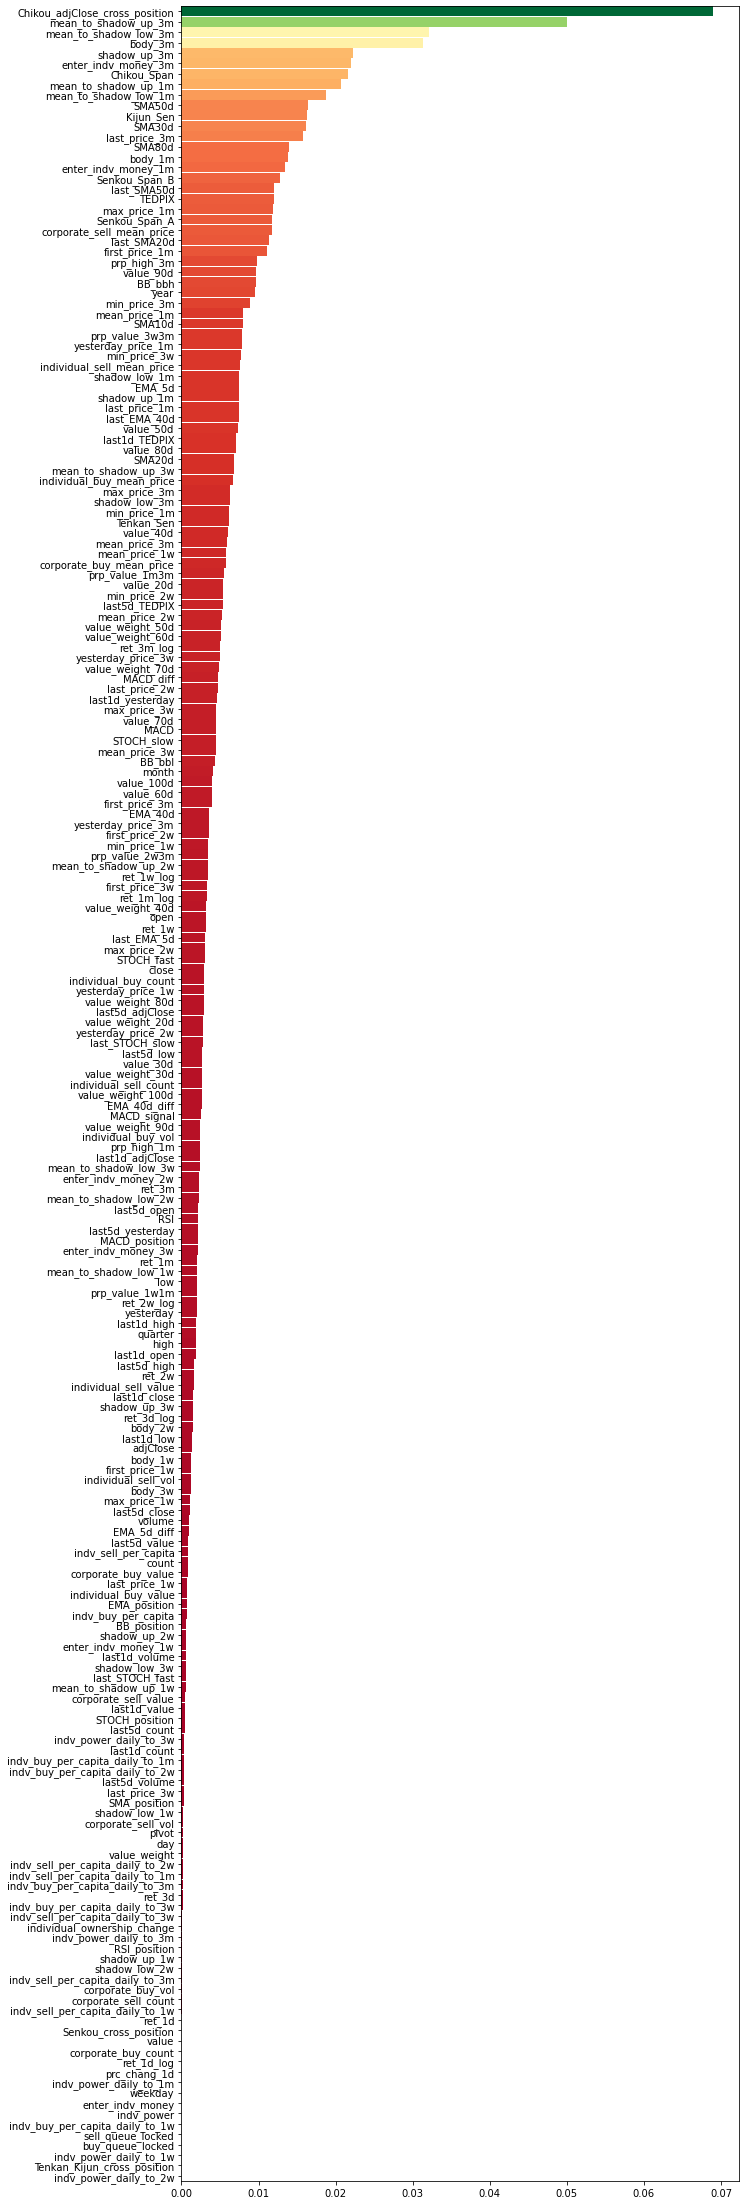

In [20]:
importance = pd.DataFrame(
    {
        'Features': initFeatures.iloc[:, 2:-2].columns,
        'Scores': featureImport
    }
).sort_values(by = ['Scores'])

plt.figure(figsize = (10, 40))
plt.tight_layout()

plt.barh(
    y = importance['Features'],
    width = importance['Scores'],
    height = 0.95,
    color = plt.cm.get_cmap('RdYlGn')(importance['Scores'] / max(importance['Scores']))
)
plt.margins(y = 0)

In [21]:
def convertLabel(df, colName):
    name = str(colName + '01')
    df.loc[initFeatures[colName] == -1, name] = 0
    df[name] = df[name].fillna(1)
    return df
    
labelPred = np.concatenate((trainPred, testPred), axis = 0)
initFeatures['labelPred'] = labelPred
labelProb = np.concatenate((trainProb, testProb), axis = 0)[:,1]
initFeatures['labelProb'] = labelProb

initFeatures

,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,quarter,month,day,weekday,shadow_up_1w,shadow_low_1w,body_1w,mean_to_shadow_up_1w,mean_to_shadow_low_1w,shadow_up_2w,shadow_low_2w,body_2w,mean_to_shadow_up_2w,mean_to_shadow_low_2w,shadow_up_3w,shadow_low_3w,body_3w,mean_to_shadow_up_3w,mean_to_shadow_low_3w,shadow_up_1m,shadow_low_1m,body_1m,mean_to_shadow_up_1m,mean_to_shadow_low_1m,shadow_up_3m,shadow_low_3m,body_3m,mean_to_shadow_up_3m,mean_to_shadow_low_3m,max_price_1w,min_price_1w,mean_price_1w,first_price_1w,last_price_1w,yesterday_price_1w,max_price_2w,min_price_2w,mean_price_2w,first_price_2w,last_price_2w,yesterday_price_2w,max_price_3w,min_price_3w,mean_price_3w,first_price_3w,last_price_3w,yesterday_price_3w,max_price_1m,min_price_1m,mean_price_1m,first_price_1m,last_price_1m,yesterday_price_1m,max_price_3m,min_price_3m,mean_price_3m,first_price_3m,last_price_3m,yesterday_price_3m,prp_high_1m,prp_high_3m,prp_value_1w1m,prp_value_2w3m,prp_value_3w3m,prp_value_1m3m,prc_chang_1d,ret_1d,ret_3d,ret_1w,ret_2w,ret_1m,ret_3m,ret_1d_log,ret_3d_log,ret_1w_log,ret_2w_log,ret_1m_log,ret_3m_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,last5d_open,last5d_high,last5d_low,last5d_adjClose,last5d_value,last5d_volume,last5d_count,last5d_yesterday,last5d_close,last5d_TEDPIX,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_weight,value_weight_20d,value_weight_30d,value_weight_40d,value_weight_50d,value_weight_60d,value_weight_70d,value_weight_80d,value_weight_90d,value_weight_100d,BB_bbh,BB_bbl,BB_position,Tenkan_Sen,Kijun_Sen,Chikou_Span,Senkou_Span_A,Senkou_Span_B,Tenkan_Kijun_cross_position,Senkou_cross_position,Chikou_adjClose_cross_position,EMA_5d,EMA_5d_diff,last_EMA_5d,EMA_40d,EMA_40d_diff,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,enter_indv_money,indv_buy_per_capita,indv_sell_per_capita,indv_power,enter_indv_money_1w,indv_buy_per_capita_daily_to_1w,indv_sell_per_capita_daily_to_1w,indv_power_daily_to_1w,enter_indv_money_2w,indv_buy_per_capita_daily_to_2w,indv_sell_per_capita_daily_to_2w,indv_power_daily_to_2w,enter_indv_money_3w,indv_buy_per_capita_daily_to_3w,indv_sell_per_capita_daily_to_3w,indv_power_daily_to_3w,enter_indv_money_1m,indv_buy_per_capita_daily_to_1m,indv_sell_per_capita_daily_to_1m,indv_power_daily_to_1m,enter_indv_money_3m,indv_buy_per_capita_daily_to_3m,indv_sell_per_capita_daily_to_3m,indv_power_daily_to_3m,pivot,label,cat_label,labelPred,labelProb
0,1388-02-14,2009-05-04,14.0,15.0,14.0,15.0,3.759837e+09,2080737.0,204.0,15.0,15.0,8638.3,1388.0,1.0,2.0,14.0,2.0,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.00000,-0.066667,0.066667,-0.057576,0.075758,0.071429,0.000000,0.214286,-0.189223,0.096491,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.000000,15.0,15.0,15.0,16.0,14.0,15.136364,15.0,16.0,15.0,18.0,14.0,15.350877,14.0,17.0,14.0,1.071429,1.071429,0.349193,0.253204,0.326386,0.327252,0.0,0.000000,0.000000,0.000000,5.551115e-17,0.004762,-0.045133,0.000000,0.000000,0.000000,0.000000,0.000000,-0.064539,0.0,0.0,15.0,15.0,14.0,15.0,2.382522e+09,1358340.0,147.0,15.0,14.0,8584.6,15.0,15.0,15.0,15.0,1.460205e+09,815360.0,122.0,15.0,15.0,8518.1,3.

In [23]:
def plotLabel(df, trainPred, testPred):
    
    date = df['date']
    price = df['adjClose']
    label = df['label']
    neutralIndex = df['pivots'] == 0
    trainBuy = df.loc[df.index < len(trainPred)].loc[trainPred == 1].index 
    trainSell = df.loc[df.index < len(trainPred)].loc[trainPred == -1].index
    trainTestBorder = df.loc[df.index == len(trainPred)].index
    testBuy = df.loc[df.index >= len(trainPred)].loc[testPred == 1].index 
    testSell = df.loc[df.index >= len(trainPred)].loc[testPred == -1].index
    
    plt.figure(figsize = (30, 15))
    plt.title('Price of Mobarakeh Steel Company', fontsize = 15)
    plt.plot(
        date,
        price,
        color = 'blue',
        lw = 3,
        label = 'Price'
    )    
    plt.plot(
        date.iloc[np.where(~neutralIndex)], 
        price.iloc[np.where(~neutralIndex)],
        color = 'black',
        lw = 2,
        label = 'ZigZag'
    )


    # train
    plt.scatter(
        date.iloc[trainSell] , 
        price.iloc[trainSell],
        color = 'red',
        s = 30,
        label = 'Sell Position based on RF (on train dataset)'
    )
    plt.scatter(
        date.iloc[trainBuy], 
        price.iloc[trainBuy],
        color = 'green',
        s = 30,
        label = 'Buy Position based on RF (on train dataset)'
    )
    plt.yscale('log')

    plt.axvline(date.iloc[trainTestBorder], color = 'purple', label = 'Train-Test Border')

    # test
    plt.scatter(
        date.iloc[testSell] , 
        price.iloc[testSell],
        color = 'red',
        s = 30,
        label = 'Sell Position based on RF (on test dataset)'
    )
    plt.scatter(
        date.iloc[testBuy], 
        price.iloc[testBuy],
        color = 'green',
        s = 30,
        label = 'Buy Position based on RF (on test dataset)'
    )
    plt.yscale('log')
    plt.legend()

# print(f'Return in passive invesitng in train section: {(initFeatures["adjClose"].iloc[len(trainPred) - 1]  / initFeatures["adjClose"].iloc[0]):0.0%}')
# print(f'Return in passive invesitng in test section: {(initFeatures["adjClose"].iloc[-1]  / initFeatures["adjClose"].iloc[len(trainPred)]):0.0%}')

# print(f'Max return in train section based on zigzag: {((initFeatures["prc_chang_1d"] * initFeatures["label01"].shift(2)).iloc[:len(trainPred)].sum() / initFeatures["adjClose"].iloc[0]):0.0%}')
# print(f'Max return in test section based on zigzag: {((initFeatures["prc_chang_1d"] * initFeatures["label01"].shift(2)).iloc[len(trainPred):].sum() / initFeatures["adjClose"].iloc[len(trainPred)]):0.0%}')

# print(f'Return in train section based on prediction: {((initFeatures["prc_chang_1d"] * initFeatures["labelPred01"].shift(2)).iloc[:len(trainPred)].sum() / initFeatures["adjClose"].iloc[0]):0.0%}')
# print(f'Return in test section based on prediction: {((initFeatures["prc_chang_1d"] * initFeatures["labelPred01"].shift(2)).iloc[len(trainPred):].sum() / initFeatures["adjClose"].iloc[len(trainPred)]):0.0%}')
plotLabel(initFeatures, trainPred, testPred)

KeyError: 'pivots'

# Bayesian Optimization

In [ ]:
# def rfcScore(
#     n_estimators,
#     min_samples_split,
#     min_samples_leaf,
#     max_depth):
    
#     n_estimators = int(n_estimators)
#     min_samples_split = int(min_samples_split)
#     min_samples_leaf = int(min_samples_leaf)
#     max_depth = int(max_depth)
    
#     params = {
#         'n_estimators': n_estimators,
#         'criterion': 'entropy',
#         'min_samples_split': min_samples_split,
#         'min_samples_leaf': min_samples_leaf,
#         'max_depth': max_depth,
#         'max_features': 'sqrt',
#         'n_jobs': -1,
#         'random_state': 1,
#         'class_weight': 'balanced_subsample'
#     }

#     rfc = RandomForestClassifier(
#         **params
#     )

#     score = cross_val_score(
#         rfc, 
#         X = X_train,
#         y = y_train,
#         scoring = 'f1_weighted'
#     ).mean()

#     return score

# def RFClf(train_data, train_label, test_data, test_label, params):
    
#     clf = RandomForestClassifier(
#         n_estimators = int(params['n_estimators']),
#         max_depth = int(params['max_depth']),
#         min_samples_leaf = int(params['min_samples_leaf']),
#         min_samples_split = int(params['min_samples_split']),
#         criterion = 'entropy',
#         class_weight = 'balanced_subsample',
#         random_state = 0
#     )

#     clf.fit(train_data, train_label)
    
#     trainPred = clf.predict(train_data)
#     testPred = clf.predict(test_data)

#     trainProb = clf.predict_proba(train_data)
#     testProb = clf.predict_proba(test_data)

#     featureImport = clf.feature_importances_

#     trainClassReport = metrics.classification_report(train_label, trainPred)
#     testClassReport = metrics.classification_report(test_label, testPred)

#     return trainPred, testPred, trainProb, testProb, featureImport, trainClassReport, testClassReport

# rfcBound = {
#     'n_estimators': (100, 200),
#     'min_samples_split': (2, 5),
#     'min_samples_leaf': (1, 5),
#     'max_depth': (4, 8)
# }
# optimizer = BayesianOptimization(
#     f = rfcScore, 
#     pbounds = rfcBound,
#     random_state = 1
# )
# optimizer.maximize(
#     init_points = 3,
#     n_iter = 5,
# )

# print(f"Selected parameters: {optimizer.max['params']}\n")

# trainPred, testPred, trainProb, testProb, featureImport, trainClassReport, testClassReport = RFClf(X_train, y_train, X_test, y_test, optimizer.max['params'])

# print(f'Training classification report:\n{trainClassReport}')
# print(f'Testing classification report:\n{testClassReport}')